# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
from IPython.display import display, HTML
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import sklearn

import statsmodels.api as sm 
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import pi
from math import *

from scipy import integrate
from numpy import inf
from sklearn.neighbors import KernelDensity
from sklearn import mixture
from matplotlib.patches import Ellipse

from windrose import WindroseAxes
from windrose import WindAxes

/Users/cqcn1991/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 1.2 Read Data

In [2]:
# ipath = './data/NCDC/boscombe_down/3466726903106dat.txt'
# ipath = './data/NCDC/ciampino/6240476818161dat.txt'
ipath = './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"
uipath = unicode(ipath , "utf8")
file2 = open(uipath)
df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.drop(['USAF', 'NCDC', 'I','Type' ,'QCP','Q','Q.1','I.1','Unnamed: 12'], 1,inplace=True)
df.rename(columns={'Date':'date','Dir': 'dir', 'Spd':'speed'}, inplace=True)
df.describe()

,date,HrMn,dir,speed
count,523949.000000,523949.000000,523949.000000,523949.000000
mean,19960957.108138,1154.187698,216.937656,8.730526
std,158147.533663,667.329057,137.692199,37.601270
min,19291001.000000,0.000000,10.000000,0.000000
25%,19860110.000000,600.000000,150.000000,4.600000
50%,19981127.000000,1150.000000,210.000000,6.700000
75%,20100329.000000,1700.000000,280.000000,9.800000
max,20150801.000000,2350.000000,999.000000,999.900000


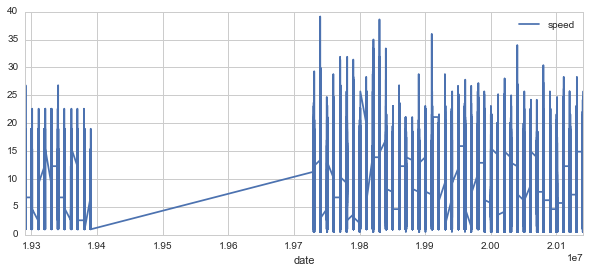

In [3]:
# select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] < 20150000) ]
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

In [4]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
df.rename(columns={'speed':'speed_mps'}, inplace=True)
df['speed']=df['speed_mps']
df['speed']=df['speed_mps']*1.943845
df['speed'] =  df['speed'].apply(lambda x: int(round(x)))

In [5]:
# Data Selection
# Marham, date >1973
# Ciampino, date： 1973~2014
if "ciampino" not in ipath: 
    df = df[ (df['date'] > 19730000) & (df['date'] < 20150000)]
    df = df[df['HrMn'] % 100 <= 0.1]
else: 
    # For Roma Ciampino
    df = df[ (df['date'] > 19720000) & (df['date'] < 20150000)]
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]

In [6]:
df.describe()

,date,HrMn,dir,speed_mps,speed
count,353491.000000,353491.00000,353491.000000,353491.000000,353491.000000
mean,19935265.744723,1151.10710,203.557007,7.446540,14.478637
std,121251.377074,691.12767,93.825886,3.821445,7.427810
min,19730101.000000,0.00000,10.000000,0.500000,1.000000
25%,19830628.000000,600.00000,140.000000,4.600000,9.000000
50%,19931104.000000,1200.00000,210.000000,6.700000,13.000000
75%,20040628.000000,1700.00000,280.000000,9.800000,19.000000
max,20141231.000000,2300.00000,360.000000,39.100000,76.000000


## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,
19740111,19740111,400,190,39.1,76,41,36
19910103,19910103,600,250,36.0,70,44,46
20040421,20040421,1100,160,34.0,66,33,32
19781228,19781228,1800,200,31.9,62,36,38
19770406,19770406,1800,330,31.9,62,32,30
19831018,19831018,1400,240,31.4,61,31,24
19770623,19770623,1000,110,31.4,61,47,50
19790509,19790509,100,310,31.4,61,45,48
19741111,19741111,100,220,29.9,58,8,4


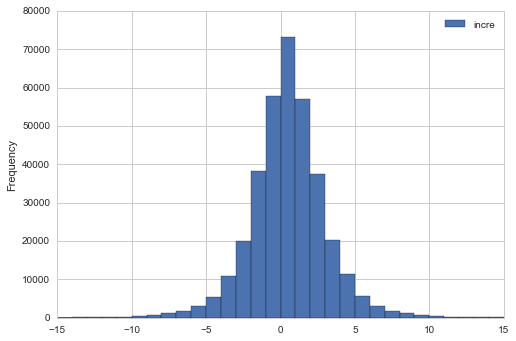

In [7]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [8]:
# Simple Artefacts Handling
df =  df[ (df['incre'] < 20)&(df['incre_reverse'] < 20)]
df = df[df['dir'] % 10 <= 0.1]
df = df[df['speed'] >= 0.1 ]

After Simple Aretefacts Handling

In [9]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,
19741111,19741111,100,220,29.9,58,8,4
19740128,19740128,500,200,28.8,56,15,5
19760120,19760120,800,280,28.8,56,8,6
19890213,19890213,1500,290,28.8,56,6,6
19930121,19930121,2100,270,28.8,56,8,6
19930117,19930117,500,270,28.3,55,12,3
20111208,20111208,1400,270,28.3,55,3,6
20111208,20111208,1200,260,27.8,54,2,2
19791217,19791217,100,240,27.8,54,1,2


### 1.3.2 Sampling Equality, and Time Shift Comparison

1800    14861
1200    14856
1500    14854
900     14825
600     14772
1400    14754
1700    14754
1100    14749
800     14744
1900    14734
1600    14732
1000    14726
2100    14723
1300    14721
300     14719
2000    14696
700     14683
2200    14654
100     14643
500     14643
2300    14637
400     14637
200     14624
0       14586
Name: HrMn, dtype: int64

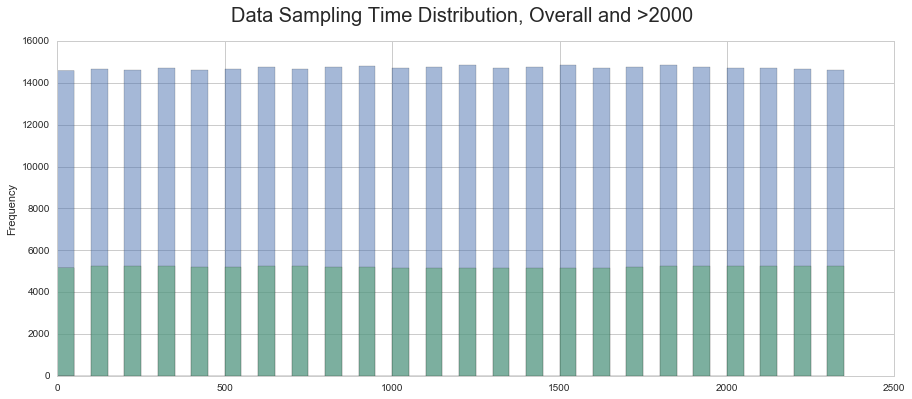

In [10]:
# Ensure data sampled equally
display(df['HrMn'].value_counts())
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)
df['HrMn'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['HrMn'].plot(kind='hist', alpha=0.5,figsize=(15, 6),bins=bins)

plt.suptitle('Data Sampling Time Distribution, Overall and >2000', fontsize = 20)

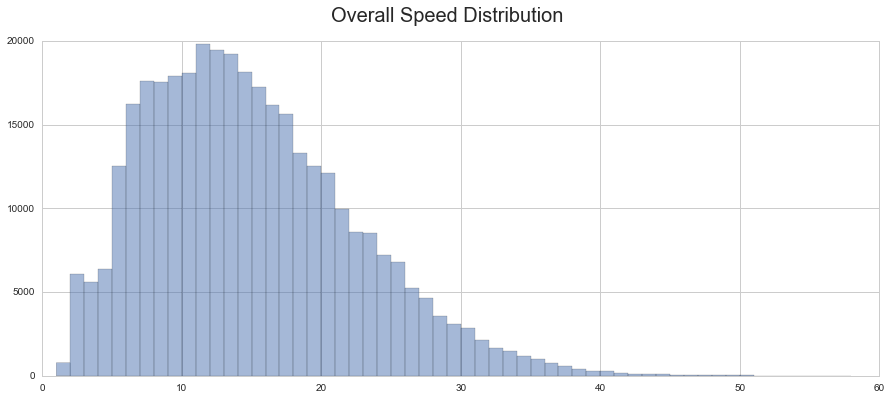

In [11]:
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
plt.suptitle('Overall Speed Distribution', fontsize = 20)

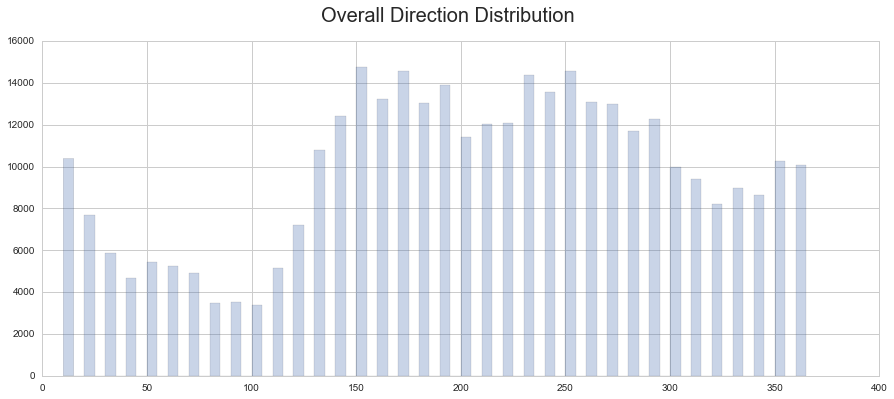

In [12]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df['dir'].hist(bins=bins, alpha=0.3,figsize=(15, 6))
plt.suptitle('Overall Direction Distribution', fontsize = 20)

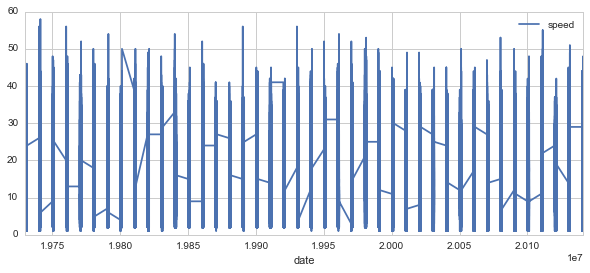

In [13]:
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

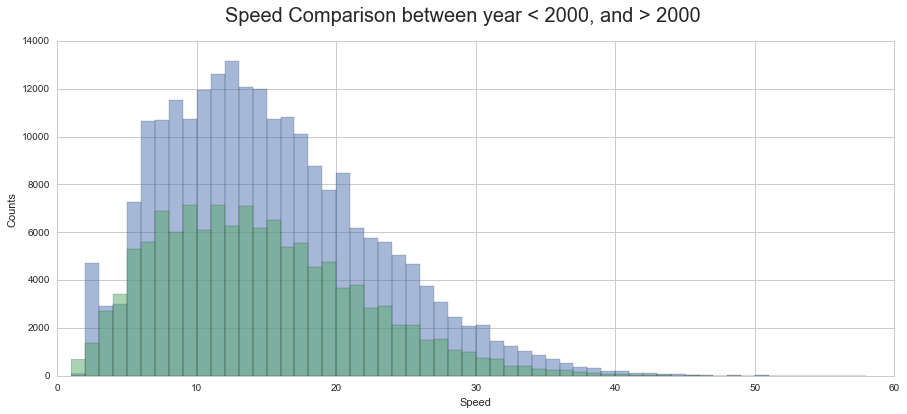

In [14]:
# Comparison between year < 2000, and > 2000, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df_temp = df[df['date'] < 20000000]
df_temp['speed'].hist(bins=bins,alpha = 0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['speed'].hist(bins=bins, alpha = 0.5,figsize=(15, 6))

plt.xlabel("Speed")
plt.ylabel("Counts")
plt.suptitle('Speed Comparison between year < 2000, and > 2000', fontsize = 20)

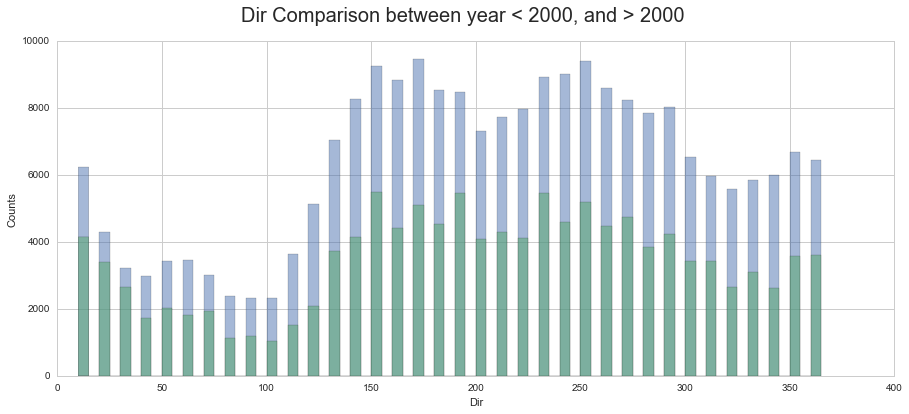

In [15]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df_temp = df[df['date'] < 20000000]
df_temp['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.xlabel("Dir")
plt.ylabel("Counts")
plt.suptitle('Dir Comparison between year < 2000, and > 2000', fontsize = 20)

In [16]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    speed_bins= np.arange(min(df.speed), max(df.speed) + 1, 1)
    for start_time in xrange(19750000,20150000,50000):
        end_time = start_time + 50000 
        sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
        sub_df['speed'].hist(bins=speed_bins,figsize=(15, 6))
        plt.suptitle(str(start_time) + '-' + str(end_time) )
        plt.show()
        
    dir_bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
    for start_time in xrange(19750000,20150000,50000):
        end_time = start_time + 50000 
        sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
        sub_df['dir'].hist(bins=dir_bins, alpha=0.3,figsize=(15, 6))
        plt.suptitle(str(start_time) + '-' + str(end_time) )
        plt.show()
    
# check_time_shift(df)

## 1.4 Re-select time range, and overview of the clean dataset

In [17]:
# if "ciampino" in ipath: 
#     # For Ciampino
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "marham" in ipath:
#     # For Marham
#     # speed still suffers from odd-even bias
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# else: 
#     # For Tiree, non is stable
#     df = df[ (df['date'] >= 20050000) & (df['date'] < 20150000)]
    
# df = df[ (df['date'] > 19720000) & (df['date'] < 20150000)]

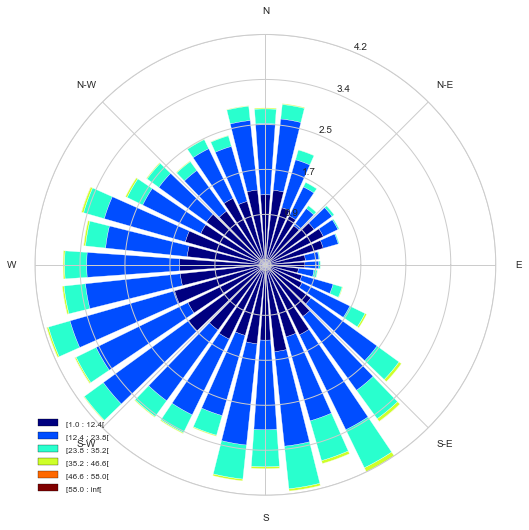

In [18]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

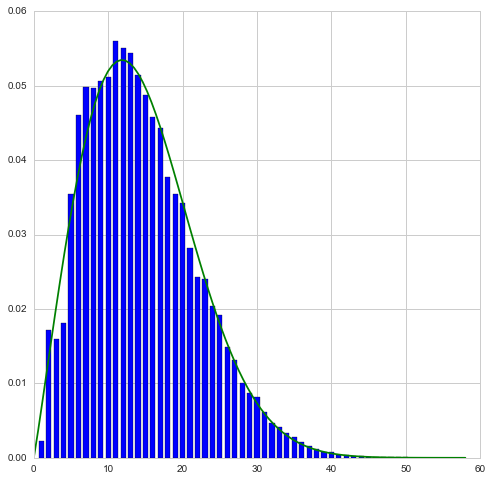

In [19]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [20]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 2.0593346575906928, 0, 16.356200466243735)
(1, 2.0593346575906928, 0, 16.356200466243735)


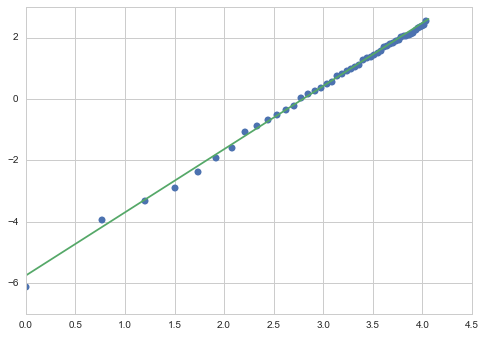

In [21]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

In [22]:
# convert from windrose system to polar system
df['dir'] = 90-df.dir
df['dir'] = df['dir'].apply(lambda x: x + 360 if x < 0 else x)
df['dir_int'] = df['dir']

In [23]:
df['dir'].value_counts().sort_index()

0       3522
10      3501
20      4918
30      5252
40      5447
50      4691
60      5885
70      7669
80     10384
90     10053
100    10253
110     8628
120     8971
130     8227
140     9422
150     9972
160    12258
170    11709
180    12966
190    13084
200    14575
210    13586
220    14385
230    12066
240    12029
250    11417
260    13917
270    13058
280    14573
290    13244
300    14759
310    12406
320    10769
330     7216
340     5154
350     3361
Name: dir, dtype: int64

In [24]:
# # Randomize angle
def randomize_angle(df):
    df['random_angle_incre'] = 0
    df['random_angle_incre'] = df['random_angle_incre'].apply(lambda x: np.random.uniform(-5,5))
    df['dir_ran']=df['dir']+df['random_angle_incre']
    bins=np.arange(min(df.dir_ran), max(df.dir_ran) + 1, 1)

    df['dir_ran']= df['dir_ran'].apply(lambda x: x + 360 if x < 0 else x)
    df['dir_ran']= df['dir_ran'].apply(lambda x: x - 360 if x > 360 else x)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran','random_angle_incre'], 1,inplace=True)
    return df

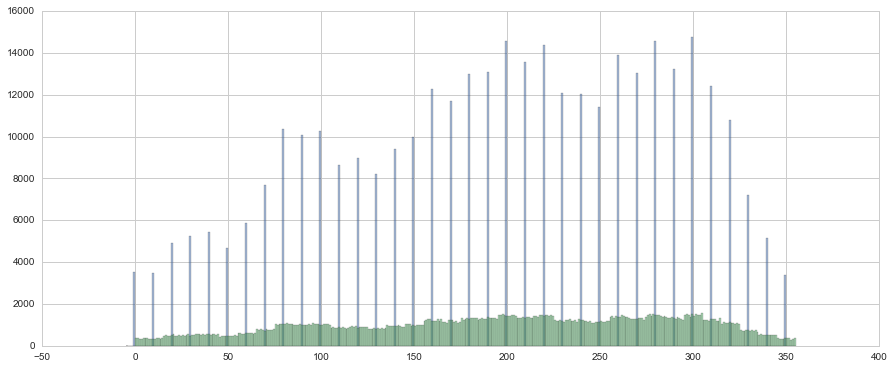

In [25]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df)

-2.59608071909 -2.75167308982


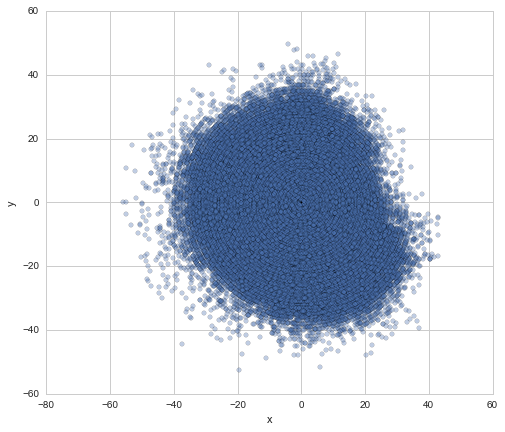

In [26]:
alpha = 0
df['phi'] = df['dir'] - alpha
df['u'] = df['speed'] * np.cos(df['phi'] * pi / 180.0)
df['v'] = df['speed'] * np.sin(df['phi'] * pi / 180.0)
df['x']=df.u
df['y']=df.v
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

df.drop(['phi', 'u','v'], 1,inplace=True)

# 2. Create Input, speed_set

In [27]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
number_of_gaussian = 3

In [28]:
fitting_range = []
for i in np.arange(-30, 31, 1):
    for j in np.arange(-30, 31, 1):
        fitting_range.append([i,j])

In [29]:
def R_square_of(MSE, kde_result):
    # R square measure:
    # https://en.wikipedia.org/wiki/Coefficient_of_determination
    y_mean = np.mean(kde_result)
    SS_tot = np.power(kde_result - y_mean,2)
    SS_tot_avg = np.average(SS_tot)

    SS_res_avg = MSE
    R_square = 1 - SS_res_avg/SS_tot_avg 

    return R_square

# 3. Kernel Density Estimation

In [30]:
sample = speed_set
kde = KernelDensity(bandwidth=1).fit(sample) # need to consider the bandwidth for different sites

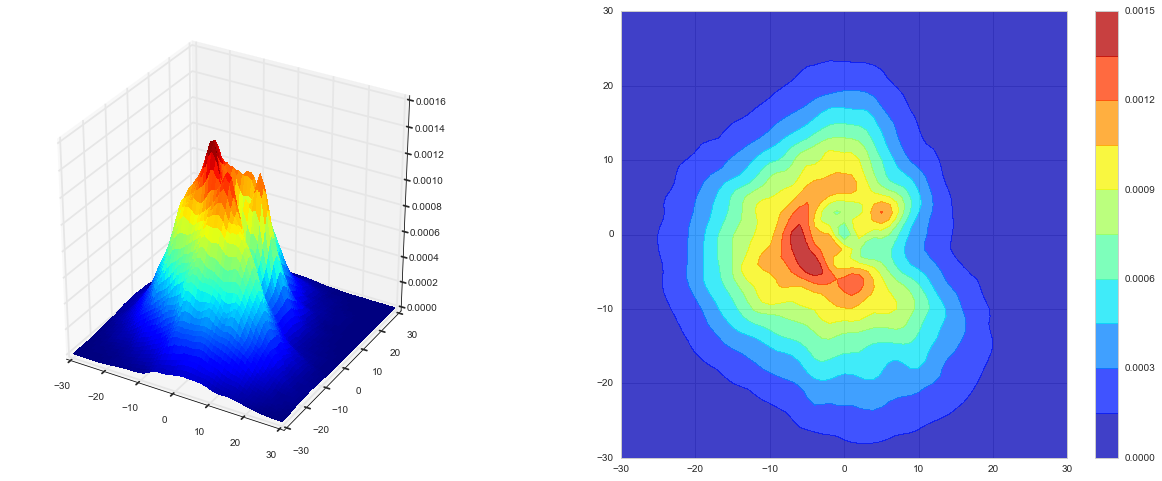

In [31]:
# Plot jPDF
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

def plot_3d_prob_density(X,Y,Z,ax = None):
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches(14, 8)
        ax = fig.gca(projection='3d')
    ax.set_aspect('equal')
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(
        X, Y, Z,rstride=1, cstride=1, cmap='jet',
                       linewidth=0, antialiased=False)

def plot_2d_prob_density(X,Y,Z,ax = None):
#   For docs, see `help(plt.contour)`
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(14, 8)
    ax.set_aspect('equal')
    CS = plt.contourf(X, Y, Z, 10, alpha=.75, cmap='jet')      
    cbar = plt.colorbar(CS)

def generate_Z_from_X_Y(X,Y, Z_func):
    XX,YY=np.meshgrid(X,Y)
    coords=np.array((XX.ravel(), YY.ravel())).T  
    Z = Z_func(coords).reshape(XX.shape)
    return Z

X = Y = np.arange(-30, 31, 1)
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)

# 4. GMM Estimation, using EM algo

In [32]:
from sklearn import mixture
import matplotlib as mpl
from matplotlib.patches import Ellipse

In [33]:
sample= speed_set

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

print clf.converged_

for i in xrange(clf.n_components):
    print clf.weights_[i], clf.means_[i], clf.covars_[i]

True
0.331231826181 [-0.74460671  6.00683308] [[ 60.63542477  -0.49789157]
 [ -0.49789157  94.33417674]]
0.323207315533 [  3.43241175 -10.77525536] [[ 90.24496926 -19.92921213]
 [-19.92921213  95.06226339]]
0.345560858286 [-10.00930454  -3.64244384] [[ 81.13296809 -11.1064495 ]
 [-11.1064495   93.58633953]]


-179.153713855 [-0.74460671  6.00683308] [ 60.62807014  94.34153137]
-138.4456752 [  3.43241175 -10.77525536] [  72.57937719  112.72785546]
-149.638299946 [-10.00930454  -3.64244384] [  74.62682869  100.09247893]


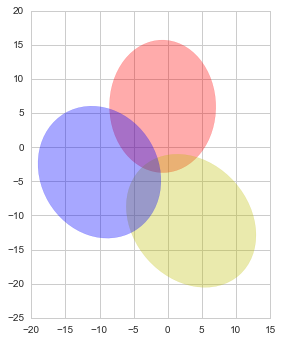

In [34]:
# how to write the for loop?
fig, ax = plt.subplots()
color_set = ['r','y','blue','grey','black']
for i in xrange(clf.n_components):
    # eigenvalues, and eigen vector
    v, w = np.linalg.eigh(clf._get_covars()[i][:2, :2])
    
    u1 = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u1[1], u1[0])
    angle = 180 * angle / np.pi
    # angle, mean, eigenvalues, 
    print angle, clf.means_[i], v
    # half width stands for std value
    ell = mpl.patches.Ellipse(xy=clf.means_[i], width=2*sqrt(v[0]), height=2*sqrt(v[1]), 
                              angle = angle, color=color_set[i], alpha = clf.weights_[i])
    ax.add_patch(ell)
    
ax.set_aspect('equal')
ax.autoscale()
plt.draw() 

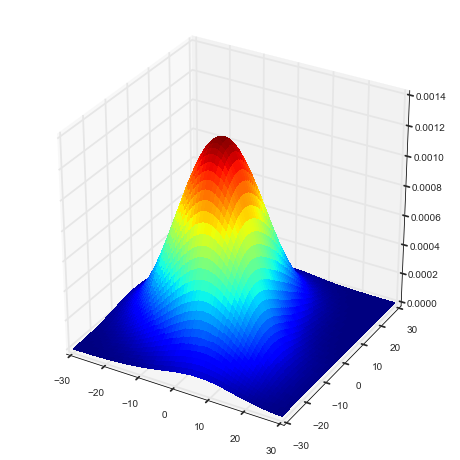

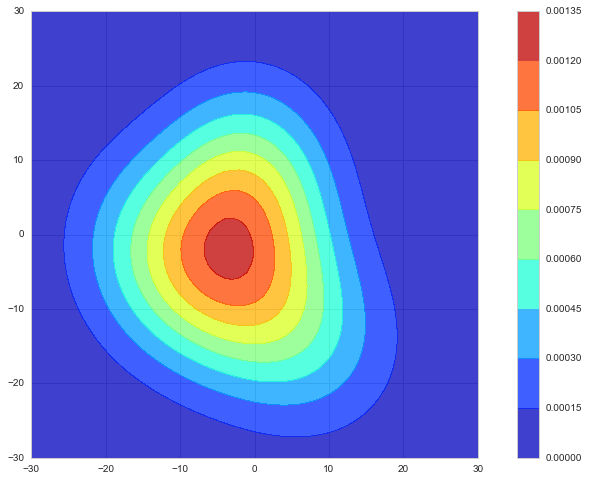

In [35]:
X = Y = np.arange(-30, 31, 1)
Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))

plot_3d_prob_density(X,Y,Z)
plot_2d_prob_density(X,Y,Z)

## GMM, EM VS. KDE

In [36]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])

In [37]:
if not 'kde_result' in globals():
    kde_result = np.exp(kde.score_samples(points))
kde_result

array([  2.16498644e-06,   1.57042191e-06,   1.36915149e-06, ...,
         5.27929887e-11,   1.00309083e-10,   7.11292876e-11])

### RMSE & R Square

In [38]:
error_array = np.power(gmm_pdf_result - kde_result,2)
MSE = np.average(error_array)
RMSE = np.sqrt(MSE)

print RMSE
R_square_of(MSE, kde_result)

5.8926840384e-05


0.96774863640081388

# 5. Least Square Prob Estimation

In [39]:
if not 'kde' in globals():
    sample = speed_set
    kde = KernelDensity(bandwidth=1.0).fit(sample) 

In [40]:
points = fitting_range

In [41]:
# very slow if the dataset is too large, e.g. 100,000
if not kde_result.all():
    kde_result = np.exp(kde.score_samples(points))
print kde_result
print len(kde_result)

[  2.16498644e-06   1.57042191e-06   1.36915149e-06 ...,   5.27929887e-11
   1.00309083e-10   7.11292876e-11]
3721


In [42]:
# GMM result
def read_gmm_em_result(clf):
    print 'GMM EM Result:'
    gmm_em_result = []
    for i in xrange(number_of_gaussian):
        weight = clf.weights_[i]
        meanx,meany=clf.means_[i].tolist()
        sigx,sigy = np.sqrt(clf.covars_ [i][0,0]), np.sqrt(clf.covars_ [i][1,1])
        rho = clf.covars_ [i][0,1]/(sigx*sigy)
        gaussian_params = weight, meanx,meany, sigx,sigy,rho
        gmm_em_result.extend(gaussian_params)
        print gaussian_params
    return gmm_em_result

gmm_em_result = read_gmm_em_result(clf)

GMM EM Result:
(0.33123182618094593, -0.7446067060556596, 6.006833075491649, 7.7868751606441711, 9.7125782747028353, -0.0065831996920614156)
(0.32320731553267318, 3.4324117521028183, -10.775255356026976, 9.4997352202841778, 9.7499878659873414, -0.21516644973454932)
(0.34556085828638156, -10.00930454164224, -3.642443844537237, 9.0073840867987602, 9.6740032836870409, -0.12745894922049308)


In [43]:
from scipy.stats import multivariate_normal

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]
        
def create_gaussian_2d(meanx,meany,sigx,sigy,rho):
    sigxy = rho*sigx*sigy
    return multivariate_normal(mean=[meanx,meany], cov=[[sigx**2,sigxy],[sigxy,sigy**2]], allow_singular=True)
        
def group_gmm_param_from_gmm_param_array(gmm_param_array, sort_group = True):
    # from 17-1 -> 6-n array
    gmm = list(chunks(gmm_param_array,6))
    if sort_group:
        gmm = sorted(gmm, key=itemgetter(0),reverse=True) # reorder by fraction, from big to small
    return gmm

def generate_gmm_pdf_from_grouped_gmm_param(gmm):
    gaussian_group=[]
    for gaussian_param in gmm:
        f,u,v,sigu,sigv,rho = gaussian_param
        g = create_gaussian_2d(u,v,sigu,sigv,rho)
        gaussian_group.append([f,g])
    def mixed_model_pdf(points):
        result = 0
        for (f,g) in gaussian_group:
            result = result + f*g.pdf(points)
        return result
    return mixed_model_pdf   

In [44]:
def square_error(gmm, kde_result): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Calculate the sum of square error
    error_array = np.power(mixed_model_pdf(points) - kde_result,2) # kde returns log prob, need to convert it
    mse = np.average(error_array)
    rmse = np.sqrt(mse)
    result = np.log(rmse)
    return result

# from GMM,EM 
x0 = gmm_em_result

# sum of every 6th element, which is the fraction of each gaussian
cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1}] 
bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: square_error(x0, kde_result),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

  status: 0
 success: True
    njev: 117
    nfev: 2349
     fun: -9.9819413005718953
       x: array([  0.06322048,   4.17823651,   6.93991764,   4.67705668,
         4.53611732,  -0.43830685,   0.71539293,  -2.13713373,
        -6.54675789,  11.29446815,  10.23755803,  -0.33868315,
         0.2213866 ,  -4.84734167,   7.17868324,   8.10255121,
        11.01435946,   0.62066048])
 message: 'Optimization terminated successfully.'
     jac: array([  3.36925983e-01,   0.00000000e+00,   0.00000000e+00,
         1.19209290e-07,   1.19209290e-07,   3.57627869e-07,
         3.36935043e-01,  -1.19209290e-07,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.36931944e-01,   1.19209290e-07,   1.19209290e-07,
         1.19209290e-07,   2.38418579e-07,  -1.31130219e-06,
         0.00000000e+00])
     nit: 117

## LRMSE VS. KDE

In [45]:
# Least Root Mean Square Error result
exp(result.fun)

4.6227241047832265e-05

In [46]:
# RMSE / Mode
print exp(result.fun)/np.max(kde_result)
print exp(result.fun)/np.mean(kde_result)

0.031611162083
0.174922454999


In [47]:
MSE = np.square(exp(result.fun))
MSE_log = result.fun
R_square = R_square_of(MSE, kde_result)

print MSE, MSE_log
print R_square

2.13695781489e-09 -9.98194130057
0.980151955721


In [48]:
from operator import itemgetter, attrgetter, methodcaller
import pprint
pp = pprint.PrettyPrinter()

gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
pp.pprint(gmm)

[array([  0.71539293,  -2.13713373,  -6.54675789,  11.29446815,
        10.23755803,  -0.33868315]),
 array([  0.2213866 ,  -4.84734167,   7.17868324,   8.10255121,
        11.01435946,   0.62066048]),
 array([ 0.06322048,  4.17823651,  6.93991764,  4.67705668,  4.53611732,
       -0.43830685])]


GMM Plot Result
0.715392927693 [[-2.13713373 -6.54675789]] [  8.68363474  12.52865089] 53.1009000652
0.221386596353 [[-4.84734167  7.17868324]] [  5.61193641  12.46890613] 328.339216216
0.0632204759534 [[ 4.17823651  6.93991764]] [ 3.45021672  5.52695433] 46.9969391804


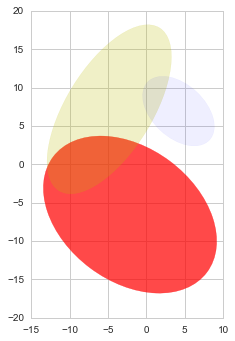

In [49]:
color_set = ['r','y','blue','grey','black', 'pink', 'pink','pink']
def plot_gmm_ellipses(gmm, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    print 'GMM Plot Result'
    for i, g in enumerate(gmm):
        xy_mean = np.matrix([g[1],g[2]])
        sigx, sigy, sigxy = g[3],g[4],g[5]*g[3]*g[4]
        cov_matrix = np.matrix([[sigx**2, sigxy], [sigxy, sigy**2]])

        # eigenvalues, and eigen vector
        w, v = np.linalg.eigh(cov_matrix)

        uu = v[0] / np.linalg.norm(v[0])
        angle_arc = -(np.arctan2(uu[0,1], uu[0,0])+np.pi)
        # rorate angle, counter clock wise
        angle = - 180 * angle_arc / np.pi

        transform_matrix = np.matrix([[np.cos(angle_arc ), -np.sin(angle_arc )], [np.sin(angle_arc ), np.cos(angle_arc )]])
        xy_mean_in_uv = transform_matrix * xy_mean.T

        # print fraction, rotation agnle, u v mean(in standalone panel), std
        print g[0], xy_mean, np.sqrt(w), angle

        ell = mpl.patches.Ellipse(xy=xy_mean.T, width=2*sqrt(w[0]), height=2*sqrt(w[1]), 
                                  angle = angle, color = color_set[i], alpha = g[0])
        ax.add_patch(ell)

    ax.autoscale()
    ax.set_aspect('equal')
    return plt.show() 

plot_gmm_ellipses(gmm)

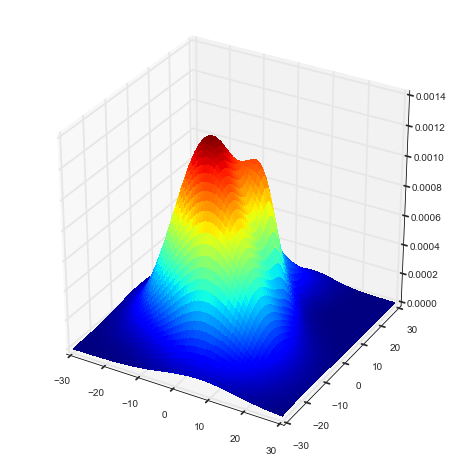

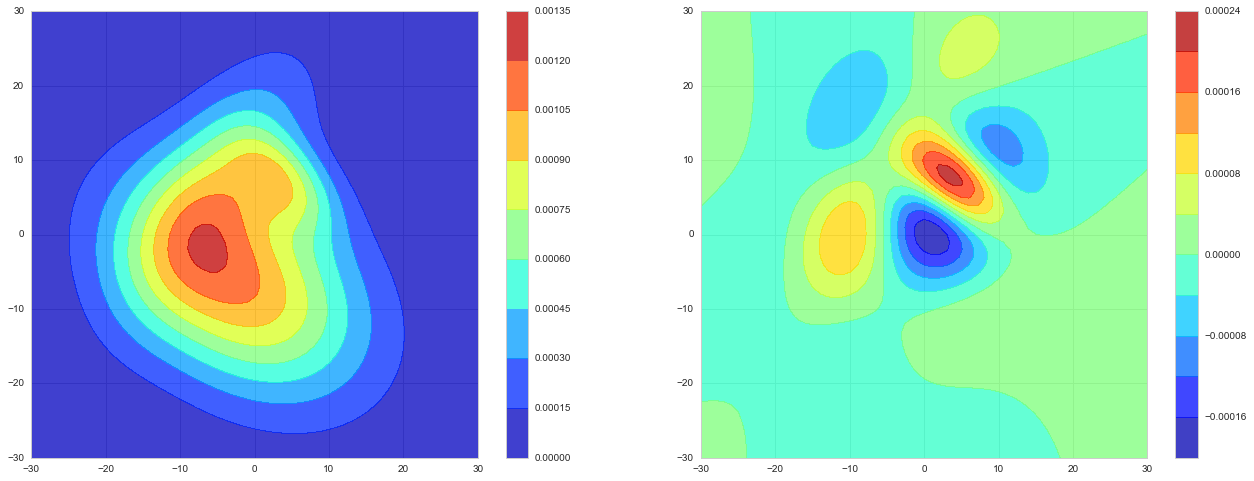

In [50]:
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)

X = Y = np.arange(-30, 31, 1)
Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument
plot_3d_prob_density(X,Y,Z)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,Z,ax1)

def residule_between_kde_and_gmm(points):
    kde = np.exp(clf.score_samples(points)[0])
    gmm = mixed_model_pdf(points)
    return gmm - kde

Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)

In [51]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.linspace(0,50)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

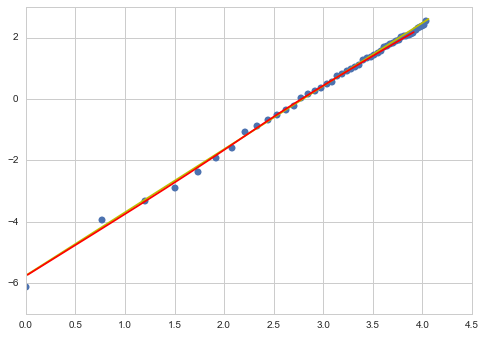

In [52]:
# Plot v-p points, empirical distribution
sample = df.speed
ecdf = sm.distributions.ECDF(sample)
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# Weibull distribution
x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

In [53]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36)
y_vals =[integrate.nquad(f, [[0, inf],[x_val, x_val+np.pi/18]]) for x_val in x_vals]

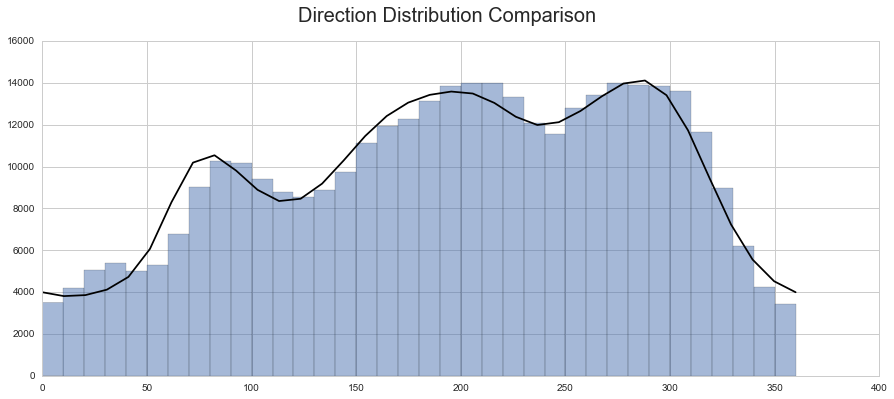

In [54]:
x, y_ = x_vals, y_vals
# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y = np.array(zip(*y_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x/np.pi*180, y,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

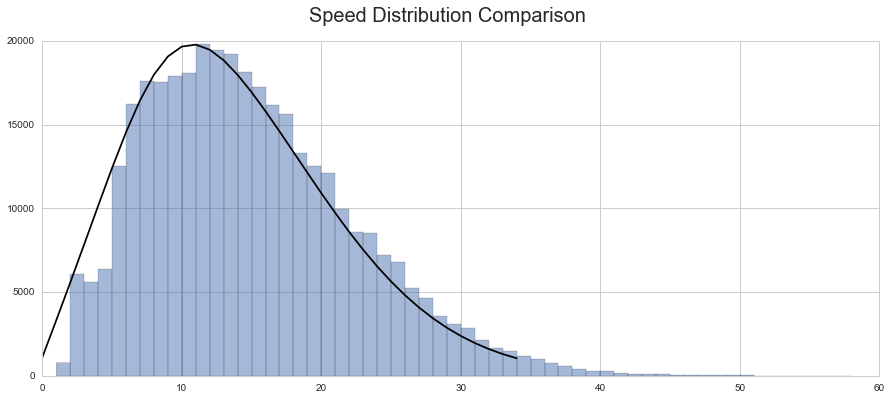

In [55]:
# Calculate Speed Distribution
x_vals = np.arange(0, 35, 1)
y_vals =[integrate.nquad(f, [[x_val, x_val+1],[0, 2*np.pi]]) for x_val in x_vals]

x, y_ = x_vals, y_vals
y = np.array(zip(*y_)[0])*len(df.speed)

bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x, y,'-', color='black')
plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

In [56]:
# # Loop through degree and speed

# all_count = len(df.speed)
# def f(V,theta):
#     return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

# chi_square_array = []
# # Data are stored in 10,360,10; speed in 0,1,2,3
# for angle in xrange(10,370,10):
#     for speed in xrange(1,35):
#         sub_df = df[(df['dir_int'] == angle) & (df['speed'] == speed)]
#         angle_arc = angle/180*np.pi
#         incre = np.pi/36
#         p_j =integrate.nquad(f, [[speed-1, speed],[angle_arc-incre, angle_arc+incre]])
#         chi_square_array.append(p.power(len(sub_df)-p_j[0]*all_count,2)/p_j[0]*all_count)

# chi_square_array

# # x_vals = np.linspace(0,2*np.pi, num=36)
# # y_vals =[integrate.nquad(f, [[0, inf],[x_val, x_val+np.pi/18]]) for x_val in x_vals]

# Cross Validation, to check the number of ellipse to be fitted

In [57]:
if "ciampino" in ipath: 
    # For Ciampino
    df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
elif "marham" in ipath:
    # For Marham
    df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
else: 
    # For Tiree, non is stable
    df = df[ (df['date'] >= 20050000) & (df['date'] < 20150000)]

In [58]:
from sklearn.cross_validation import train_test_split, KFold

def plot_speed_and_angle_distribution(df):
    plt.subplot(1,2,1)
    bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
    df['speed'].hist(bins=bins,figsize=(15, 6))
    plt.subplot(1,2,2)    
    bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
    df['dir'].hist(bins=bins, alpha=0.3, figsize=(15, 6))
    plt.show()
    
def fit_gmm(df, number_of_gaussian = 3):
    # 1. Create Input, speed_set
    sub_speed_set = np.array(zip(df.x, df.y))
    sample = sub_speed_set
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = KernelDensity(bandwidth=1).fit(sample) 
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    kde_result = np.exp(kde.score_samples(points))
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. LRMSE fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
 
    result = sp.optimize.minimize(
        lambda x0: square_error(x0, kde_result),
        x0,
        method = 'SLSQP', 
        bounds = bonds,
        constraints=cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    MSE = np.square(exp(result.fun)) # result.fun is logged RMSE
    R_square = R_square_of(MSE, kde_result)
    gmm = group_gmm_param_from_gmm_param_array(result.x)   
    print 'Number of Iteration', result.nit
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'MSE': MSE,
        'R_square': R_square}

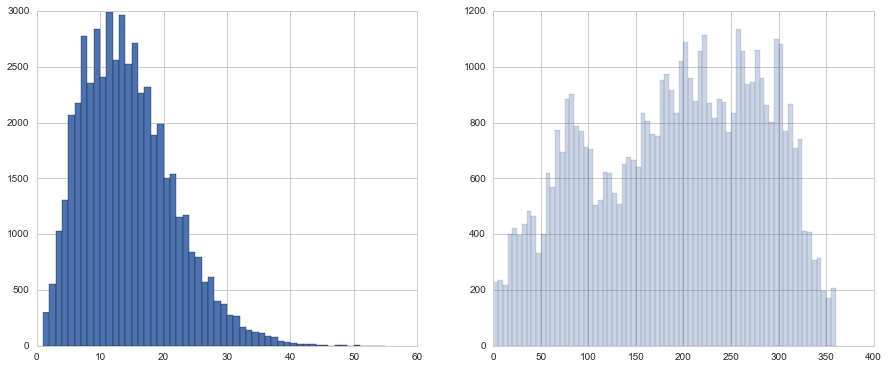

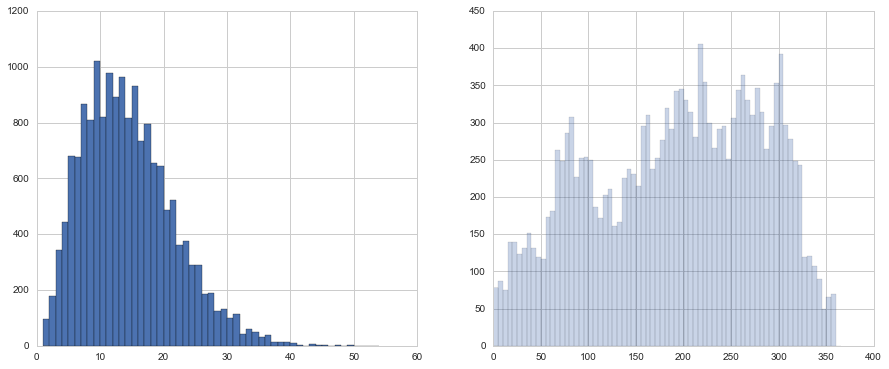

GMM EM Result:
(0.19889775878817317, -11.150808345268349, 0.08306818985697965, 8.7179553750613401, 8.9268266028284717, -0.025328393774626902)
(0.19608175100761596, -6.8161208951418635, -8.957778548170038, 8.5447353571177711, 9.3118943691490674, -0.17036532756383171)
(0.23897751689075306, -0.20111506141129423, -0.7976804712222918, 7.5045232193781466, 10.056456955678806, -0.051149731297308647)
(0.17130453671220358, 5.71778906351581, -12.258762859367828, 8.4013482938029309, 8.8351109137119277, -0.26301437594694377)
(0.19473843660125537, 0.8459312942648741, 8.82289406470979, 6.8181953478323676, 8.6724471642661545, 0.16124669266997782)
Number of Iteration 319
MSE log -20.1383635019 R Square 0.985053651168
GMM Plot Result
0.454485226295 [[-4.41317148  4.26509307]] [  7.72669993  11.12250474] 317.286554351
0.332777251051 [[ -4.05593672 -11.19274477]] [  7.01530597  12.29765288] 48.5807415287
0.0938013300464 [[  7.26461874 -10.29747809]] [ 3.93322577  7.04888098] 69.7459077263
0.0923009088567 

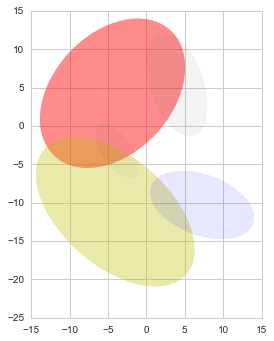

MSE log test -9.76820597966
R_square 0.980151955721


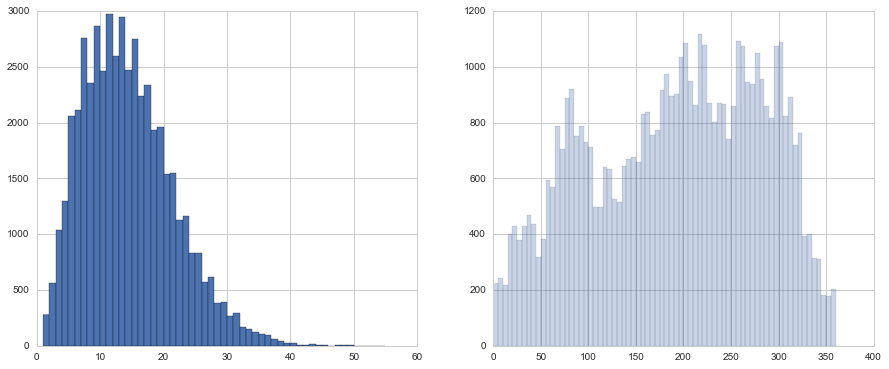

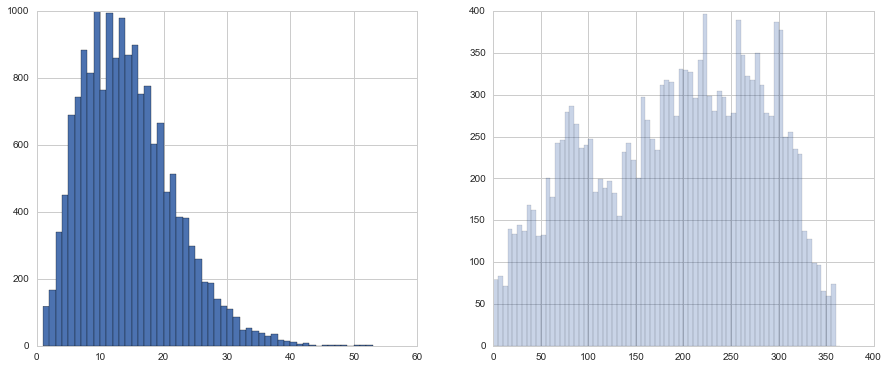

GMM EM Result:
(0.19741572160059762, -10.982444270908884, 0.3686109156418437, 8.7061260323109746, 8.9767256105624078, -0.029286039918481548)
(0.17500714161881642, 5.560862087150502, -12.294006652323338, 8.4080347394137185, 8.7805668401157035, -0.25481739530922082)
(0.19762229366812403, -7.204839022386223, -8.695693542368094, 8.539608210453423, 9.2536322202393553, -0.16860204513778554)
(0.23781569442886352, -0.10925026615836841, -0.9255105587855665, 7.5274725184361779, 10.095779469816256, -0.067403201111602987)
(0.19213914868359958, 0.8247870368680802, 8.862751954785079, 6.8042088582080558, 8.7439030977053562, 0.17246374718614835)
Number of Iteration 293
MSE log -20.2546832005 R Square 0.98667846816
GMM Plot Result
0.485970413769 [[-2.01505191 -9.3091647 ]] [  8.14107959  11.62082743] 56.7905077644
0.373623212066 [[-4.73337312  5.24787919]] [  7.55949389  11.48085166] 319.102777758
0.0593529594706 [[ 2.23899749 -6.83768634]] [ 2.60657189  9.83950441] 61.2823778223
0.0553165304117 [[ 2.0

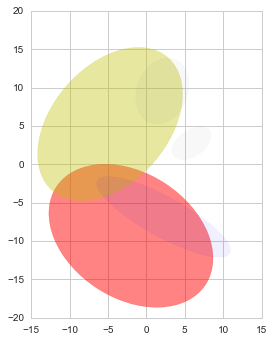

MSE log test -9.85234710692
R_square 0.980151955721


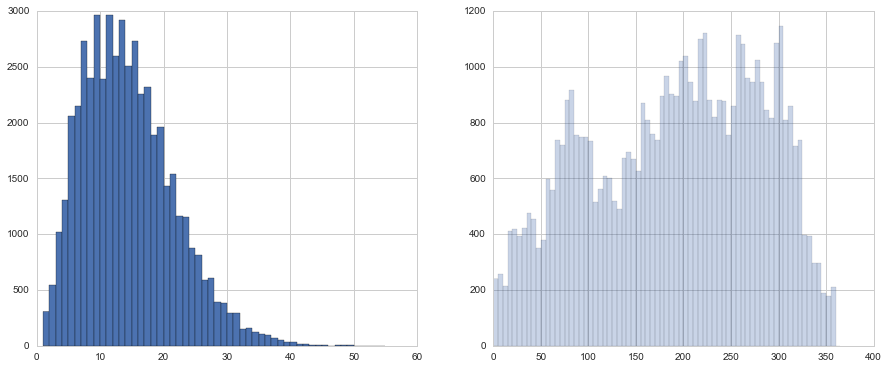

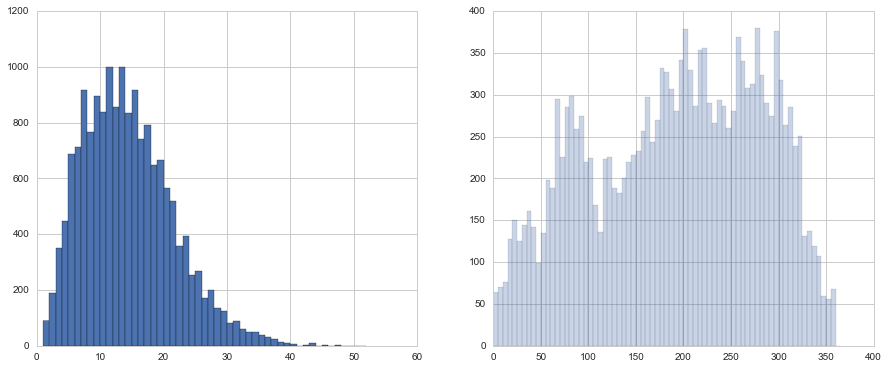

GMM EM Result:
(0.19872833910440707, -7.2883908007247475, -8.528012490582517, 8.501110906212217, 9.2600772363092823, -0.16515394791745969)
(0.2387352559314217, -0.025705745268888212, -1.0034629490971567, 7.4899895414352979, 10.105549807927666, -0.063475426916565089)
(0.17419341926499196, 5.4253464377192016, -12.508966453789293, 8.4557665725454711, 8.867085800286084, -0.24848867361700766)
(0.19340635386003072, 0.837187557288565, 8.75068843760497, 6.8330271342950528, 8.7239655369451139, 0.15549307246606336)
(0.19493663183914972, -10.940644460305414, 0.4357701055445339, 8.8663928007049471, 8.9758530521686133, -0.014540526159593401)
Number of Iteration 372
MSE log -20.1723669508 R Square 0.985573824946
GMM Plot Result
0.470848128734 [[-2.23940446 -9.34787199]] [  8.20984298  11.72346353] 56.5553715099
0.386335369573 [[-4.38281013  5.0502716 ]] [  7.80538985  11.34869214] 320.012162539
0.064307347051 [[ 2.40306442 -7.40380671]] [ 2.75895472  9.77513577] 60.032050382
0.0526760442398 [[ 1.877

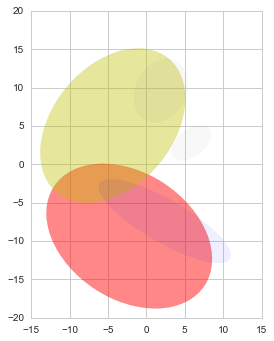

MSE log test -9.8324330021
R_square 0.980151955721


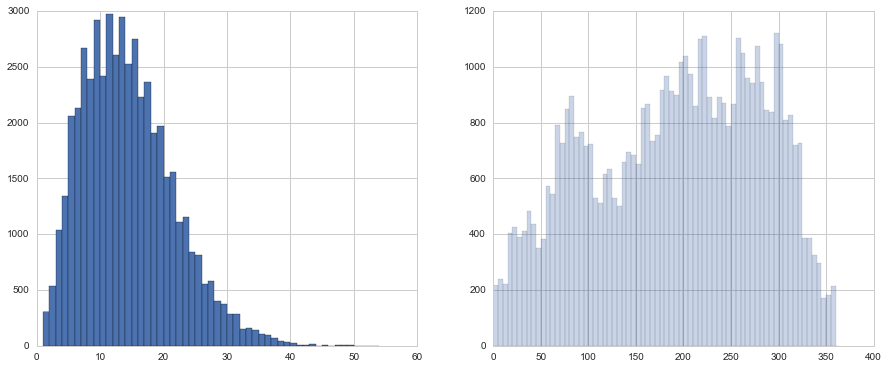

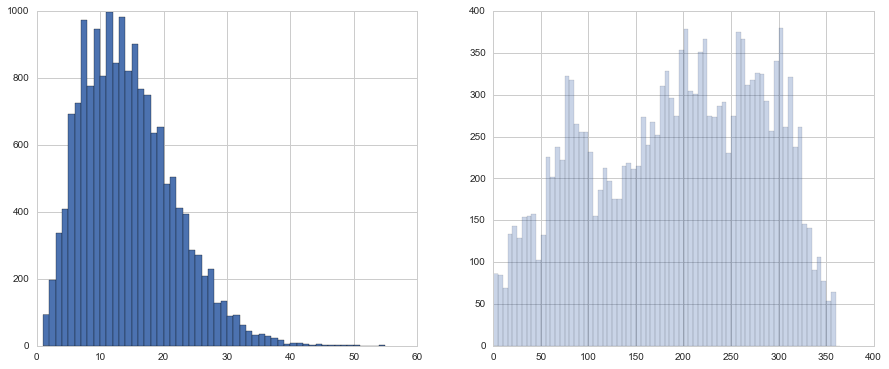

GMM EM Result:
(0.19286685581402477, -10.77464692722553, 0.8613817428973974, 8.8545306291141905, 8.986902210918192, -0.025396245984315002)
(0.17391918955243219, 5.183221684331497, -12.715655446252127, 8.5286232994725353, 8.8584275878510486, -0.23143203784006056)
(0.19679564423983348, 0.9539286747325211, 8.646803991965578, 6.6956890472418351, 8.7227716452337116, 0.148086747166428)
(0.197996669170728, -7.820328092888758, -8.09870588357615, 8.4638354733640675, 9.1494405007753592, -0.15607760423886366)
(0.23842164122298273, -0.0036696727393235678, -1.5775919617574048, 7.5535715373769055, 10.137850380135099, -0.077701745771079953)
Number of Iteration 339
MSE log -20.2267759736 R Square 0.986358448637
GMM Plot Result
0.487634093832 [[-2.14205008 -9.11413995]] [  8.1581939   11.69848136] 56.2020291541
0.36904308422 [[-4.72519524  5.0254434 ]] [  7.7696052  11.3899317] 320.680205269
0.0593505780887 [[ 2.14976304  9.92153171]] [ 3.48573597  4.71539553] 335.080037212
0.0580661917848 [[ 1.7510190

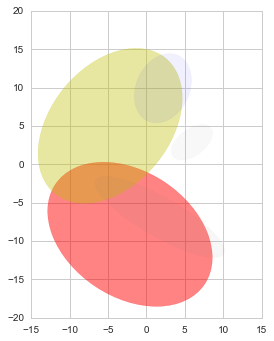

MSE log test -9.84248340557
R_square 0.980151955721


In [59]:
train, test = train_test_split(df, test_size = 0.2)
kf = KFold(len(train), n_folds=4, shuffle=True)

for train_index, test_index in kf:
    sub_df = df.iloc[train_index]
    sub_df_test = df.iloc[test_index]
    
    plot_speed_and_angle_distribution(sub_df)
    plot_speed_and_angle_distribution(sub_df_test)
    
    # 1. Train
    number_of_gaussian = 5
    result = fit_gmm(sub_df, number_of_gaussian)
    print 'MSE log', np.log(result['MSE']), 'R Square', result['R_square']
    plot_gmm_ellipses(result['gmm'])
    
    # 2. Validate
    # GMM from Train - KDE from Test
    sample = np.array(zip(sub_df_test.x, sub_df_test.y))
    kde_test = KernelDensity(bandwidth=1).fit(sample) 
    kde_result_test = np.exp(kde.score_samples(points))
    
    MSE_test = square_error(result['gmm'], kde_result_test)
    R_square_test = R_square_of(MSE, kde_result_test)
    
    print 'MSE log test', MSE_test
    print 'R_square', R_square_test

# Time Shift, Loop Through Years to See the Difference

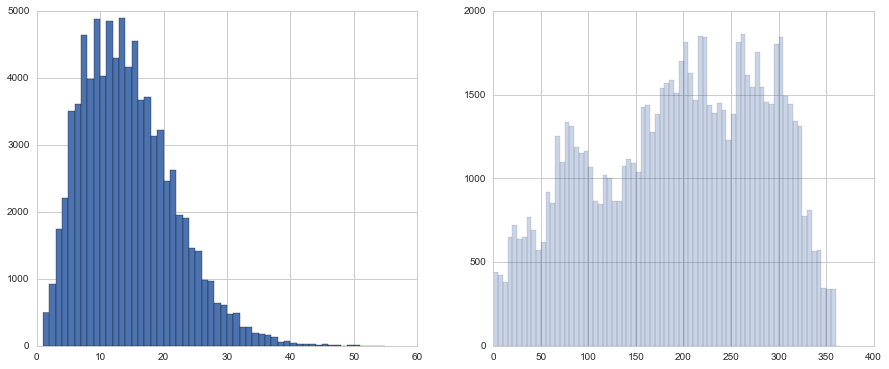

GMM EM Result:
(0.19482861850132674, 0.6732308059829553, 8.27735497315172, 6.8409088781630354, 8.8533449770575707, 0.13031431642047564)
(0.17285572919714767, 6.063867076365493, -12.081747040171585, 8.491422917490576, 8.8342964929415313, -0.24360725057476354)
(0.19203104663241177, -7.080503466601752, -9.1136512226297, 8.7476756026201716, 9.4458737627347187, -0.18890233041294902)
(0.19752357293433612, -11.122513078025346, 0.10892734113437301, 8.8970031829726217, 8.6832913528191558, -0.025287600003524181)
(0.2427610327347787, -0.27687109568987617, -1.7761578814404184, 7.7867054681205818, 9.7493109904936492, -0.11448887431995228)


TypeError: square_error() takes exactly 2 arguments (1 given)

In [60]:
# for start_time in xrange(19750000,20150000,50000):
#     end_time = start_time + 50000 
#     sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
number_of_gaussian = 5

for i in xrange(1,20):
    sub_df = df.sample(frac=1, replace=True)
    
    plt.subplot(1,2,1)
    bins = np.arange(min(sub_df.speed), max(sub_df.speed) + 1, 1)
    sub_df['speed'].hist(bins=bins,figsize=(15, 6))
    plt.subplot(1,2,2)    
    bins=np.arange(min(sub_df.dir), max(sub_df.dir) + 10, 5)
    sub_df['dir'].hist(bins=bins, alpha=0.3, figsize=(15, 6))
    plt.show()
    
    # 1. Create Input, speed_set
    sub_speed_set = np.array(zip(sub_df.x, sub_df.y))
    sample = sub_speed_set
    
    # 2. Do KDE and EM fitting, and get the resul
    kde = KernelDensity(bandwidth=1).fit(sample) 
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    points = fitting_range
    # KDE result
    kde_result = np.exp(kde.score_samples(points))
    # GMM EM result
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. Do the LRMSE fitting, do the plot
    # from GMM,EM 
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    result = sp.optimize.minimize(
        square_error,
        x0,
        method = 'SLSQP', 
        bounds = bonds,
        constraints=cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})
    print 'Number of Iteration', result.nit
    
    # exp(result.fun) is RMSE 
    MSE = np.square(exp(result.fun))
    R_square = R_square_of(MSE, kde_result)
    print 'R square:', R_square
    
    gmm = group_gmm_param_from_gmm_param_array(result.x)    
    
    fig = plt.figure(figsize=(15,8))

    # Plot KDE 
    X = Y = np.arange(-30, 31, 1)
    Z = kde_result.reshape(len(X),len(X)).T
    ax1 = fig.add_subplot(1,3,1)
    plot_2d_prob_density(X,Y,Z,ax1)
    
    # Plot GMM Density
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)
    ax2 = fig.add_subplot(1,3,2)
    plot_2d_prob_density(X,Y,Z,ax2)
    
    # Plot GMM Ellipses
    ax3 = fig.add_subplot(1,3,3)
    plot_gmm_ellipses(gmm,ax3)